Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# P3M force diagnostic

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH
output_path = OUTPUT_PATH

L = 64  # Box size in Mpc/h
N = 32  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8  # Make sure Npm/n_Tiles >= 6

go_beyond_Nyquist_ss = True  # for the summary statistics

force = True
force_hard = True
run_id = "forcediag8"

# Good set of parameters for the force diagnostic
# nPairsForceDiagnostic_spm = nPairsForceDiagnostic_p3m = 3
# nBinsForceDiagnostic = 30
# maxTrialsForceDiagnostic = int(1e9)

# Faster force diagnostic
nPairsForceDiagnostic_spm = nPairsForceDiagnostic_p3m = 3
nBinsForceDiagnostic = 20
maxTrialsForceDiagnostic = int(1e8)

# Simulation parameters
# nsteps_spm = 200
# nsteps_p3m = 200
nsteps_spm = 20
nsteps_p3m = 20

In [ ]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy import pySbmy
from pysbmy.power import PowerSpectrum
from pysbmy.field import read_field

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field
from wip3m.params import params_planck_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [ ]:
corner = 0.0
RedshiftLPT = 19.0
RedshiftFCs = 0.0
ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
cosmo = params_planck_kmax_missing.copy()
cosmo["k_max"] = k_max

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths the the force diagnostic CSVs
OutputForceDiagnostic_spm = simdir + "force_diagnostic_spm.txt"
OutputForceDiagnostic_p3m = simdir + "force_diagnostic_p3m.txt"

k_max = 2.721


### Generate the parameter files

The first preparatory step is to generate all the parameter files required for all the simulations.

To this end we use the `generate_sim_params` function defined in `params.py`.

In [5]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
lpt_params["InputWhiteNoise"] = input_white_noise_file

spm_params = common_params.copy()
spm_params["method"] = "spm"
spm_params["EvolutionMode"] = 5
spm_params["TimeStepDistribution"] = 0
spm_params["ai"] = ai
spm_params["af"] = af
spm_params["RedshiftLPT"] = RedshiftLPT
spm_params["RedshiftFCs"] = RedshiftFCs
spm_params["Npm"] = Npm
spm_params["nsteps"] = nsteps_spm
spm_params["n_Tiles"] = n_Tiles
spm_params["RunForceDiagnostic"] = True
spm_params["nPairsForceDiagnostic"] = nPairsForceDiagnostic_spm
spm_params["nBinsForceDiagnostic"] = nBinsForceDiagnostic
spm_params["OutputForceDiagnostic"] = OutputForceDiagnostic_spm
spm_params["maxTrialsForceDiagnostic"] = maxTrialsForceDiagnostic

p3m_params = common_params.copy()
p3m_params["method"] = "p3m"
p3m_params["EvolutionMode"] = 4
p3m_params["TimeStepDistribution"] = 0
p3m_params["ai"] = ai
p3m_params["af"] = af
p3m_params["RedshiftLPT"] = RedshiftLPT
p3m_params["RedshiftFCs"] = RedshiftFCs
p3m_params["Npm"] = Npm
p3m_params["nsteps"] = nsteps_p3m
p3m_params["n_Tiles"] = n_Tiles
p3m_params["RunForceDiagnostic"] = True
p3m_params["nPairsForceDiagnostic"] = nPairsForceDiagnostic_p3m
p3m_params["nBinsForceDiagnostic"] = nBinsForceDiagnostic
p3m_params["OutputForceDiagnostic"] = OutputForceDiagnostic_p3m
p3m_params["maxTrialsForceDiagnostic"] = maxTrialsForceDiagnostic

[17:40:12|INFO      ]|(wip3m.tools) Generating parameter file...
[17:40:12|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/forcediag8/example_lpt.sbmy'...
[17:40:12|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/forcediag8/example_lpt.sbmy' done.
[17:40:12|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/forcediag8/example_lpt.sbmy
SPM nsteps = 20:
[17:40:12|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/forcediag8/nsteps20_ts_spm.h5
[17:40:12|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code

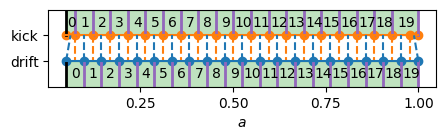

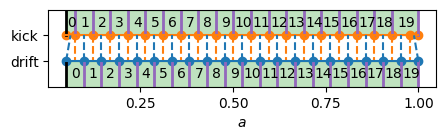

In [6]:
reset_plotting()  # Default style for Simbelmynë

generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

print(f"SPM nsteps = {nsteps_spm}:")
file_ext = f"nsteps{nsteps_spm}"  # "spm" is already in the filename
generate_sim_params(spm_params, ICs_path, wd, simdir, file_ext, force)

print(f"P3M nsteps = {nsteps_p3m}:")
file_ext = f"nsteps{nsteps_p3m}"  # "p3m" is already in the filename
generate_sim_params(p3m_params, ICs_path, wd, simdir, file_ext, force)

setup_plotting()  # Reset plotting style for this project

### Generate the initial phase

In [7]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

The second preparatory step is to compute the initial power spectrum to be used in the simulations, given the cosmological parameters and prescription specified in ``params.py``. The power spectrum is saved in `input_power_file`.

In [8]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[17:40:16|STATUS    ]|Setting up Fourier grid...
[17:40:16|STATUS    ]|Setting up Fourier grid done.
[17:40:16|STATUS    ]|Computing normalization of the power spectrum...
[17:40:16|STATUS    ]|Computing normalization of the power spectrum done.
[17:40:16|STATUS    ]|Computing power spectrum...
[17:40:16|STATUS    ]|Computing power spectrum done.
[17:40:16|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/forcediag8/input_power.h5'...
[17:40:16|DIAGNOSTIC]==|L0=64, L1=64, L2=64
[17:40:16|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=464
[17:40:16|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/forcediag8/input_power.h5' done.


## Running the simulations

We are now ready to run the actual simulations using the Simbelmynë executable. Warning: the following may take some time, even in relatively low dimension, and should not be run on a login node.

In [ ]:
pySbmy(f"{wd}example_lpt.sbmy", f"{logdir}lpt.txt")
pySbmy(f"{wd}{file_ext}_example_spm.sbmy", f"{logdir}{file_ext}_spm.txt")
pySbmy(f"{wd}{file_ext}_example_p3m.sbmy", f"{logdir}{file_ext}_p3m.txt")

[17:40:21|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/forcediag8/example_lpt.sbmy /Users/hoellinger/WIP3M/forcediag8/logs/lpt.txt
[17:40:21|INFO      ]|
[17:40:21|INFO      ]|            .-~~-.--.
[17:40:21|INFO      ]|           :         )
[17:40:21|INFO      ]|     .~ ~ -.\       /.- ~~ .
[17:40:21|INFO      ]|     >       `.   .'       <
[17:40:21|INFO      ]|    (         .- -.         )
[17:40:21|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[17:40:21|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[17:40:21|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[17:40:21|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[17:40:21|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[17:40:21|INFO      ]|             

HDF5-DIAG: Error detected in HDF5 (1.14.6):
  #000: /tmp/hdf5-20250207-38588-gjrv3m/hdf5-1.14.6/src/H5Adeprec.c line 202 in H5Aopen_name(): unable to open attribute
    major: Attribute
    minor: Can't open object
  #001: /tmp/hdf5-20250207-38588-gjrv3m/hdf5-1.14.6/src/H5VLcallback.c line 1125 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: /tmp/hdf5-20250207-38588-gjrv3m/hdf5-1.14.6/src/H5VLcallback.c line 1092 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: /tmp/hdf5-20250207-38588-gjrv3m/hdf5-1.14.6/src/H5VLnative_attr.c line 164 in H5VL__native_attr_open(): unable to open attribute: '/info/scalars/time'
    major: Attribute
    minor: Can't open object
  #004: /tmp/hdf5-20250207-38588-gjrv3m/hdf5-1.14.6/src/H5Aint.c line 514 in H5A__open(): unable to load attribute info from object header for attribute: '/info/scalars/time'
    major: Attribute
    minor

[17:40:21|STATUS    ]====|Drifting particles (using 8 cores) done.
[17:40:21|STATUS    ]==|ModuleP3M: End sPM step 10/20, time_kick:0.501250, time_drift=0.525000.
[17:40:21|TIMER     ]==|Step 10/20: Density: 0.014 CPU - 0.003 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Potential: 0.007 CPU - 0.002 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Accelerations (long-range): 0.031 CPU - 0.007 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Accelerations (short-range): 0.000 CPU - 0.000 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Kick: 0.005 CPU - 0.002 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Drift: 0.002 CPU - 0.003 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Inputs: 0.000 CPU - 0.000 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Diagnostic: 0.000 CPU - 0.000 wallclock seconds used.
[17:40:21|TIMER     ]==|Step 10/20: Outputs: 0.000 CPU - 0.000 wallclock seconds used.
[17:40:21|TIMER 

0

The logs can be monitored in the corresponding files in the `logdir` directory.

## Plot results

### Plot the evolved dark matter density fields

In [11]:
slice_ijk = (N // 2, slice(None), slice(None))
DELTA_SPM = read_field(simdir + f"nsteps{nsteps_spm}_final_density_spm.h5").data[slice_ijk]
DELTA_P3M = read_field(simdir + f"nsteps{nsteps_p3m}_final_density_p3m.h5").data[slice_ijk]
diff_p3m_spm = DELTA_P3M - DELTA_SPM

[17:41:08|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/forcediag8/nsteps20_final_density_spm.h5'...
[17:41:08|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(64.0), np.float64(0.0), np.float64(64.0), np.float64(0.0), np.float64(64.0), np.int32(32), np.int32(32), np.int32(32)]
[17:41:08|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/forcediag8/nsteps20_final_density_spm.h5' done.
[17:41:08|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/forcediag8/nsteps20_final_density_p3m.h5'...
[17:41:08|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(64.0), np.float64(0.0), np.float64(64.0), np.float64(0.0), np.float64(64.0), np.int32(32), np.int32(32), np.int32(32)]
[17:41:08|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/forcediag8/nsteps20_final_density_p3m.h5' done.


In [12]:
print(f"max(DELTA_P3M) = {np.max(DELTA_P3M)}, min(DELTA_P3M) = {np.min(DELTA_P3M)}")
print(f"max(diff) = {np.max(diff_p3m_spm)}, min(diff) = {np.min(diff_p3m_spm)}")

max(DELTA_P3M) = 13.530181884765625, min(DELTA_P3M) = -1.0
max(diff) = 9.85678768157959, min(diff) = -6.458697319030762


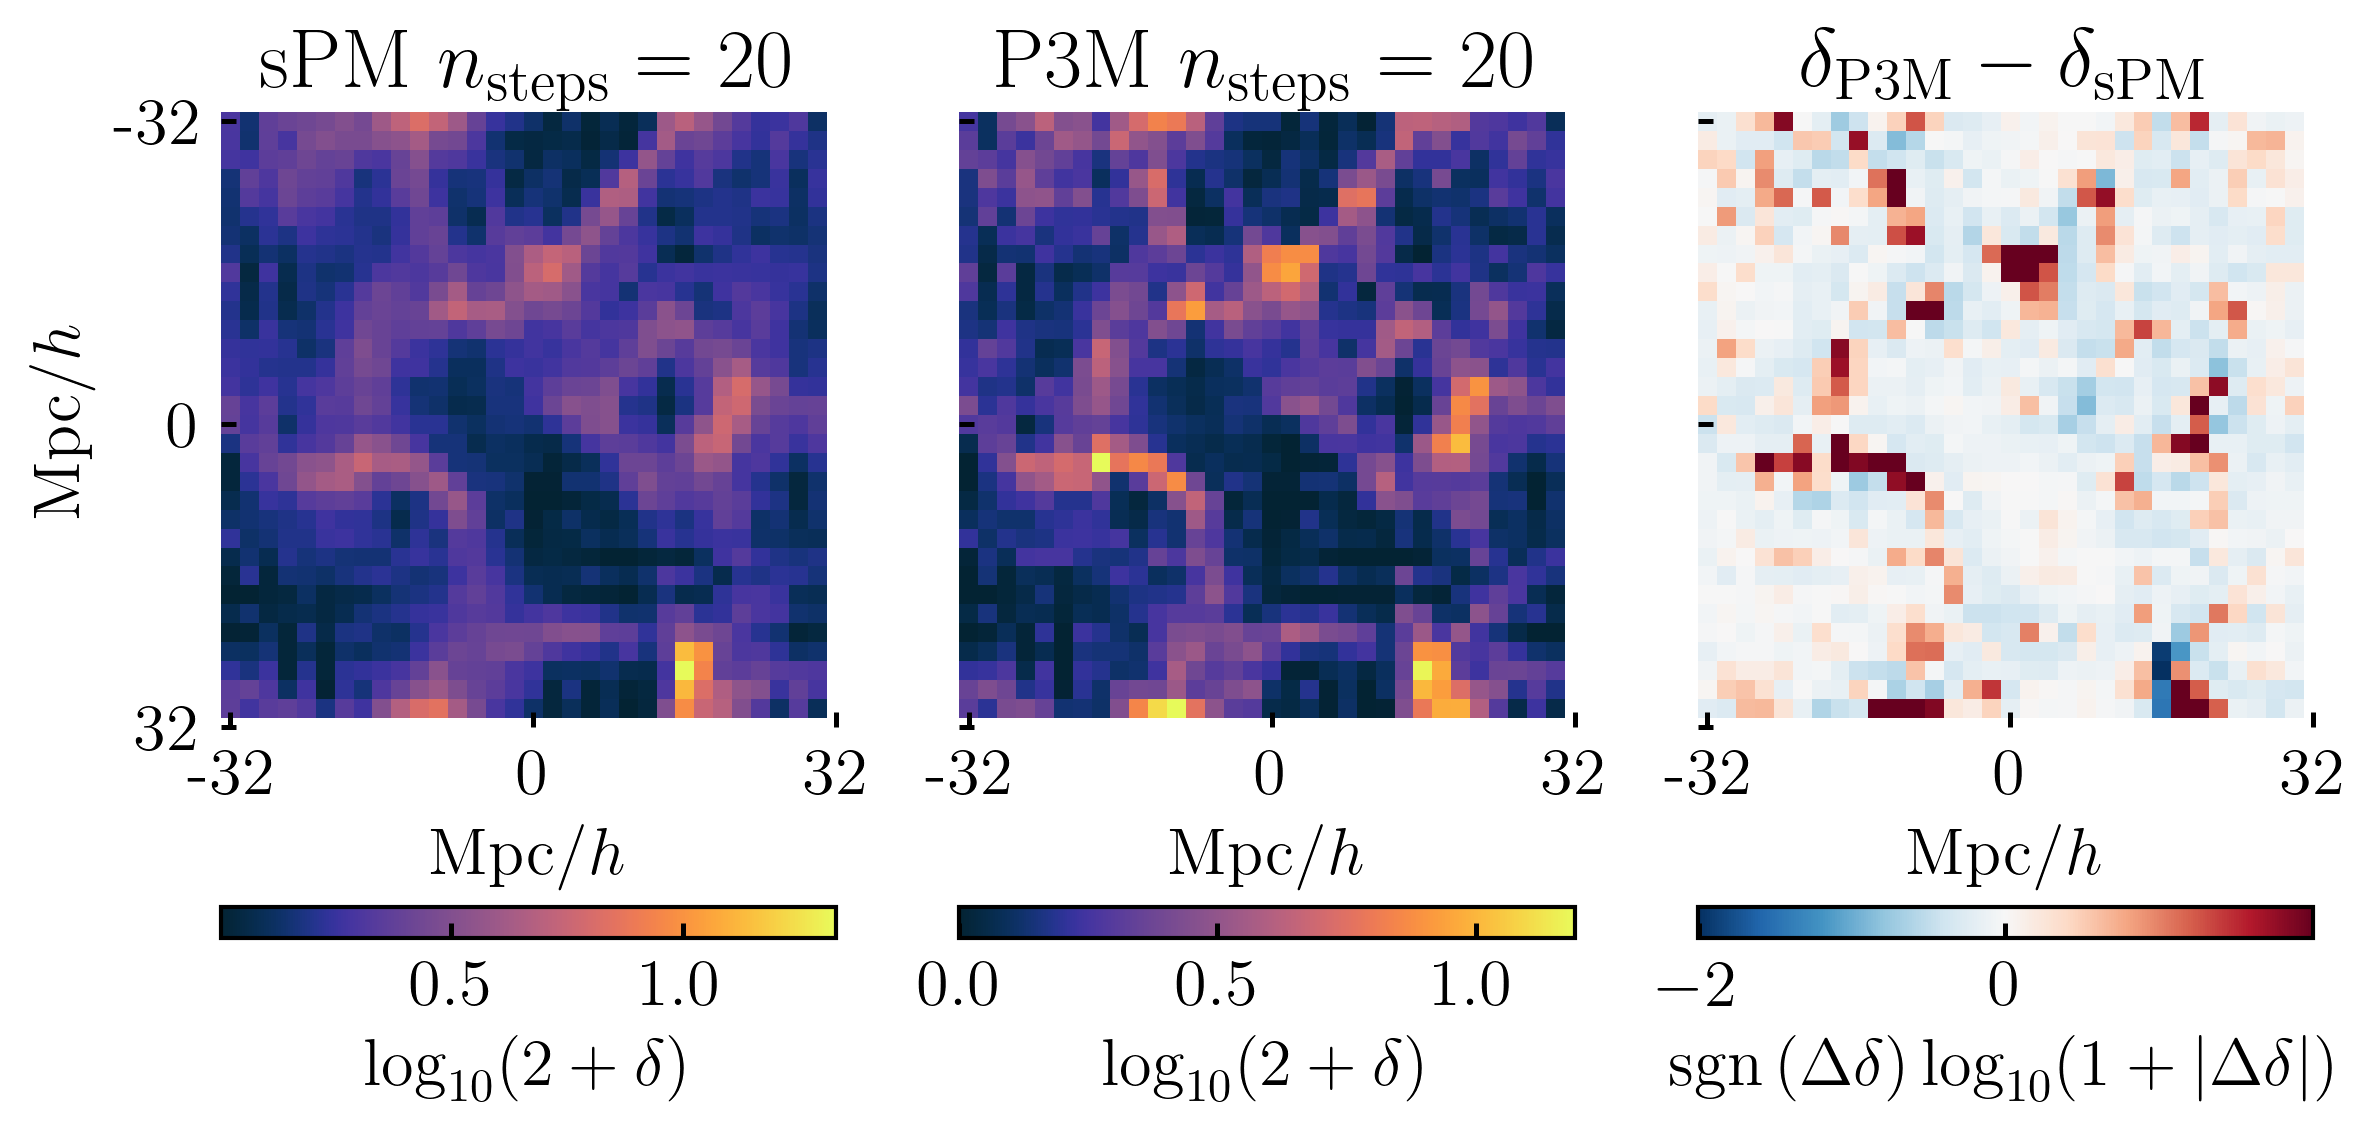

In [13]:
from matplotlib.colors import TwoSlopeNorm

fields = ["spm", "p3m", "diff_p3m_spm"]  # fields to plot

slices_dict = {
    "spm": DELTA_SPM,
    "p3m": DELTA_P3M,
    "diff_p3m_spm": diff_p3m_spm,
}
titles_dict = {
    "spm": f"sPM $n_\\mathrm{{steps}}={nsteps_spm}$",
    "p3m": f"P3M $n_\\mathrm{{steps}}={nsteps_p3m}$",
    "diff_p3m_spm": r"$\delta_{\rm P3M}-\delta_{\rm sPM}$",
}

npanels = len(fields)
fig, axs = plt.subplots(1, npanels, figsize=(3 * npanels, 4), sharey=True)

ims = []
for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        vmin = -np.log(1 + np.abs(np.min(data)))
        vmax = np.log10(1 + np.abs(np.max(data)))
        if vmin < 0 < vmax:
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        else:
            norm = plt.Normalize(vmin=vmin, vmax=vmax)
        im = ax.imshow(
            np.sign(data) * np.log(1 + np.abs(data)), cmap="RdBu_r", norm=norm
        )
    else:
        im = ax.imshow(np.log10(2 + data), cmap=cmap)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].set_yticks([0, N // 2, N])
axs[0].set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
axs[0].set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for i, ax in enumerate(axs):
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for ax, (im, key) in zip(axs, ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("diff"):
        cb.set_label(r"$\textrm{sgn}\left(\Delta\delta\right)\log_{10}(1 + |\Delta\delta|)$", fontsize=fs)
    else:
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")
figname = f"fields"
fig.savefig(
    simdir + f"{figname}.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + f"{figname}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

In [14]:
full_field_p3m = np.log10(2+read_field(simdir + f"nsteps{nsteps_p3m}_final_density_p3m.h5").data)

if N <= 128:
    fig = plotly_3d(full_field_p3m, size=N, L=L, colormap=thermal_plotly, limits="default")
else:
    # Downsample the grid for visualisation
    downsample_factor = N // 128
    downsampled_field = full_field_p3m[
        ::downsample_factor, ::downsample_factor, ::downsample_factor
    ]
    fig = plotly_3d(downsampled_field, size=N, L=L, colormap=thermal_plotly, limits="default")

fig.show()
clear_large_plot(fig)  # Uncomment to clear the Plotly figure to avoid memory issues

### Force exerted by particles on other particles

In [15]:
r1, fmag1, _ = load_force_diagnostic(OutputForceDiagnostic_spm)
r2, fmag2, _ = load_force_diagnostic(OutputForceDiagnostic_p3m)
Newton_prefactor = (L / Np)**3 / (4*np.pi)
print(f"Newton prefactor = {Newton_prefactor:.2e}")

Newton prefactor = 6.37e-01


Nyquist: 2.00 Mpc/h
Particle length: 0.12 Mpc/h
Split scale: 1.25 Mpc/h
Short-range reach: 5.62 Mpc/h


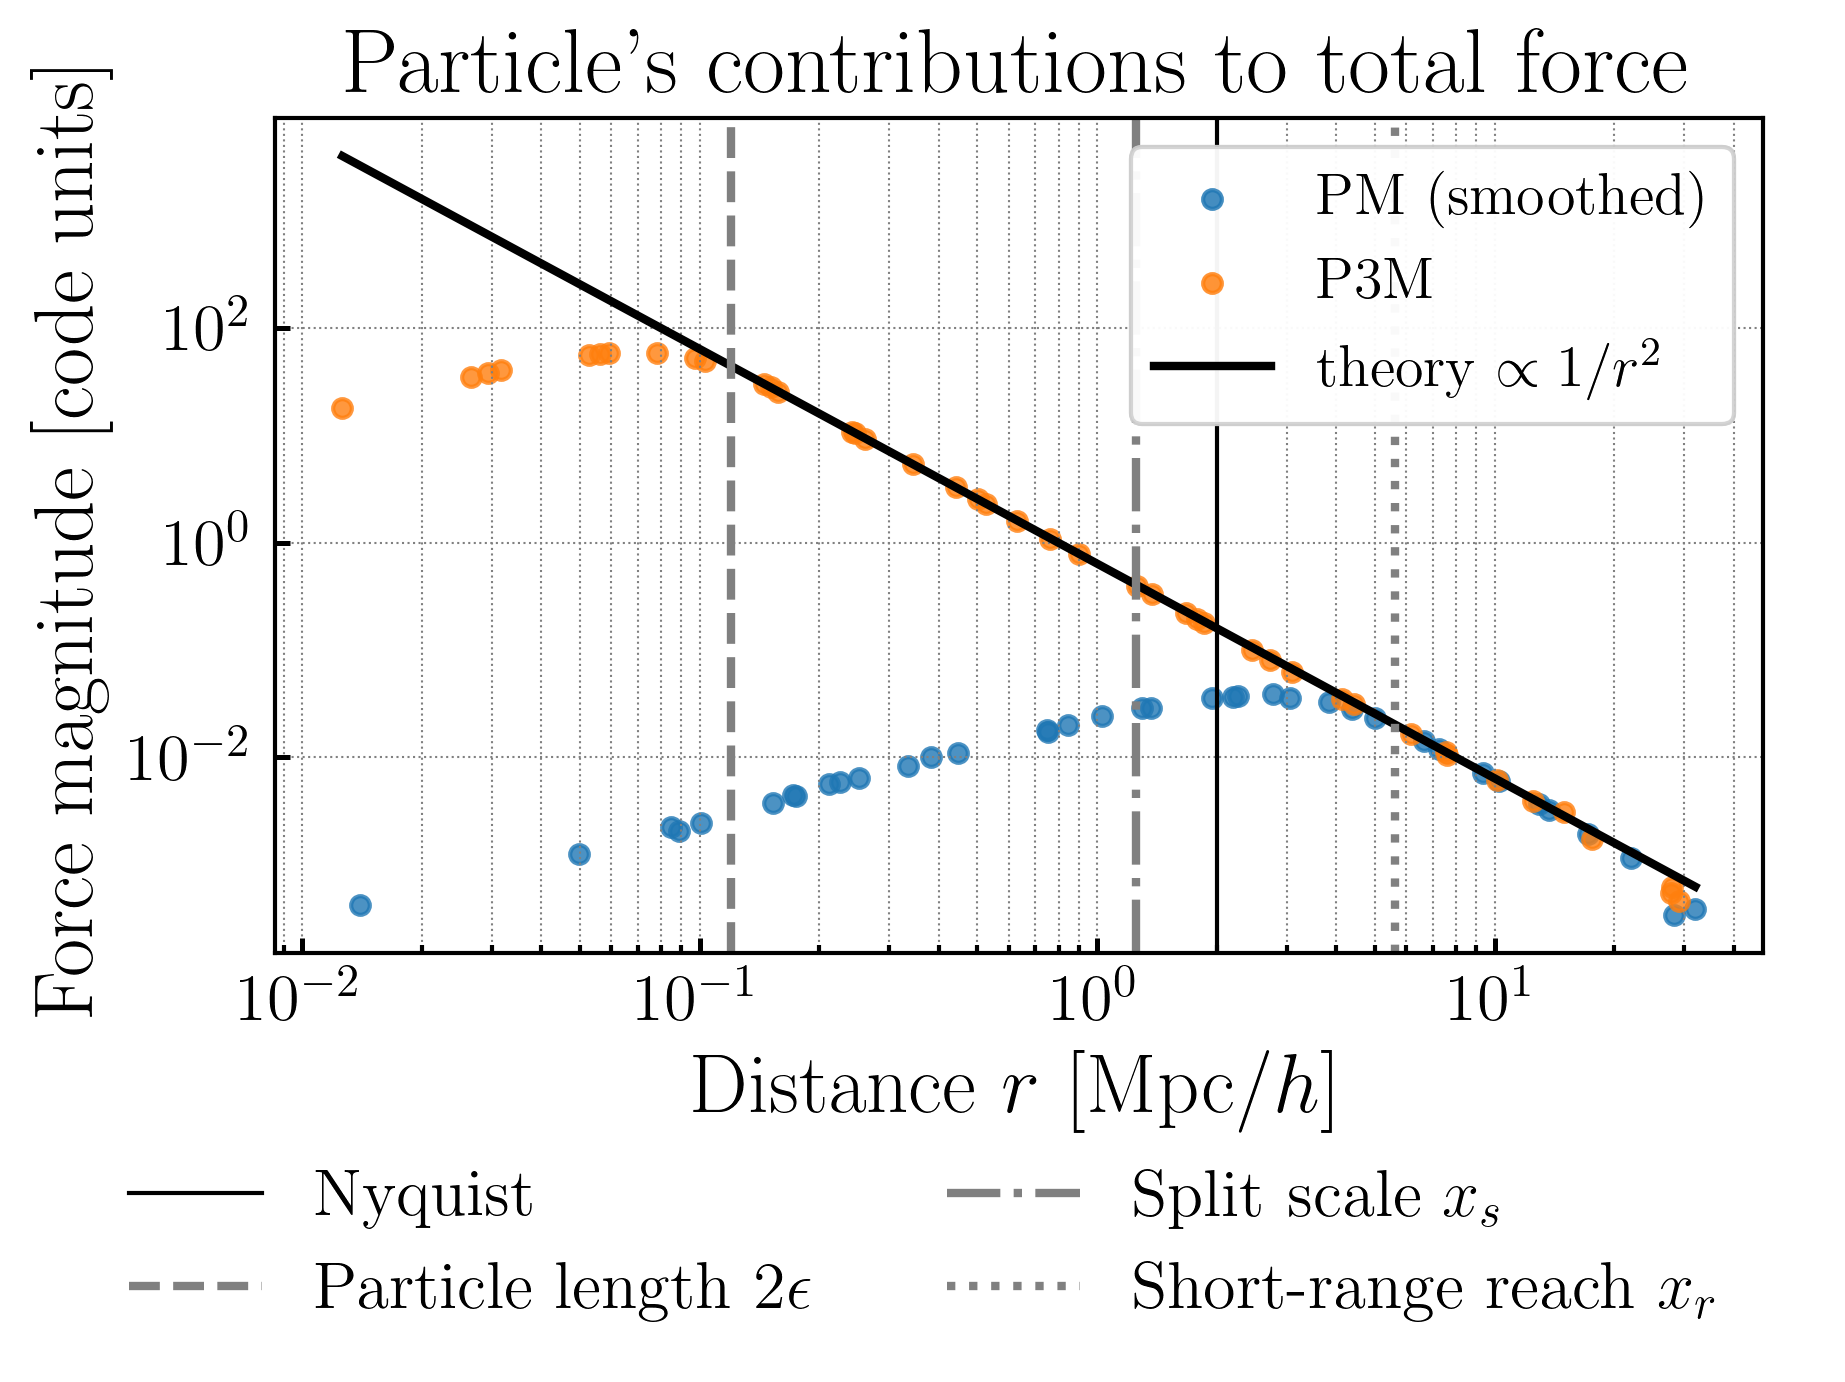

In [16]:
plot_force_distance_comparison(rr=[r1, r2], ff=[fmag1, fmag2], ll=["PM (smoothed)", "P3M"], L=L, Np=Np, Npm=Npm, a=Newton_prefactor, title="Particle's contributions to total force")#, ss=["o", "."])